In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
pip install sklearn-pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
import sklearn_pandas


In [4]:
import sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, Normalizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sklearn_pandas
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score,train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.special import boxcox1p
import csv

import warnings
warnings.filterwarnings('ignore')

In [5]:
import sys
import scipy
import numpy as np
import seaborn as sns
import sklearn
import pandas as pd

print('Environment specification:\n')
print('python', '%s.%s.%s' % sys.version_info[:3])

for mod in np, scipy, sns, sklearn, pd:
    print(mod.__name__, mod.__version__)


Environment specification:

python 3.11.7
numpy 1.26.4
scipy 1.11.4
seaborn 0.12.2
sklearn 1.2.2
pandas 2.1.4


In [6]:
import pandas as pd

# Replace 'filename.csv' with the actual filename of your CSV file
data_df = pd.read_csv('train.csv')

# Now you can work with the 'data_df' DataFrame


In [7]:
import pandas as pd

# Replace 'filename.csv' with the actual filename of your CSV file
data_df = pd.read_csv('test.csv')

# Now you can work with the 'data_df' DataFrame

In [8]:
# kaggle train data
data_df = pd.read_csv("train.csv")
# kaggle test data
test_df = pd.read_csv("test.csv")


In [9]:
all_data = pd.concat((data_df.loc[:,:], test_df.loc[:, :]))
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [10]:
#Exploratory Data Analysis and Data tidying

In [11]:
# Basic summary:
data_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: >

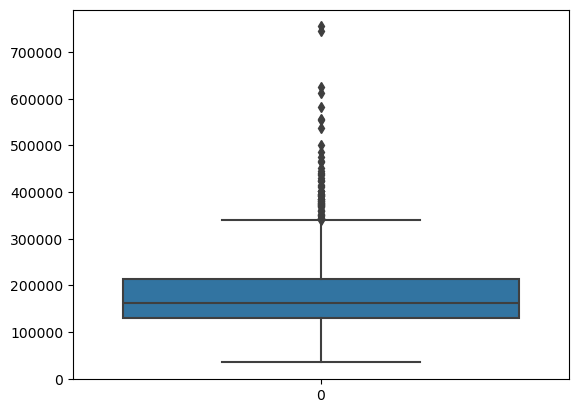

In [12]:
sns.boxplot(data_df['SalePrice'])

<Axes: xlabel='SalePrice', ylabel='Density'>

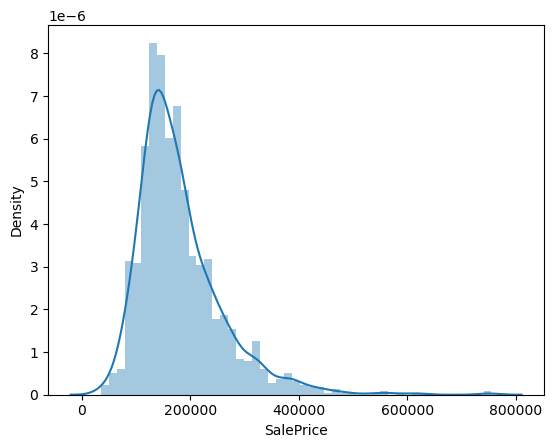

In [13]:
# The Density Plot of SalePrice
sns.distplot(data_df['SalePrice'])

In [14]:
# Positive Skeweness:
data_df['SalePrice'].skew()

1.8828757597682129

In [15]:
data_df["SalePrice"] = np.log1p(data_df["SalePrice"])

Text(0.5, 1.0, 'Density plot of SalePrice after Log Transformation')

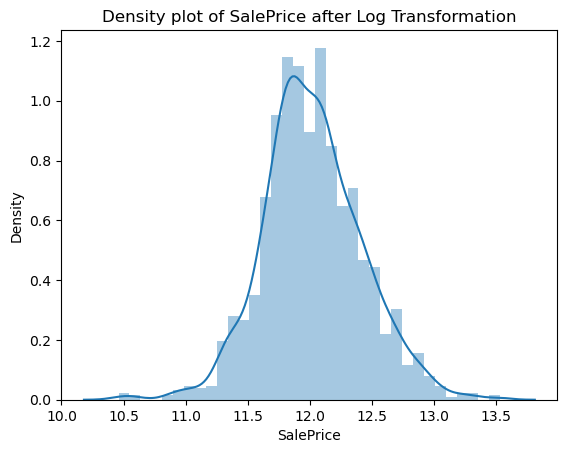

In [16]:
# SalePrice after Log-transformation
sns.distplot(data_df["SalePrice"])
plt.title("Density plot of SalePrice after Log Transformation")

In [17]:
y_train = data_df["SalePrice"]

In [18]:
col_nan = data_df.isna().sum() / data_df.shape[0]

Text(0.5, 1.0, 'Features with the highest percentage of Nan values')

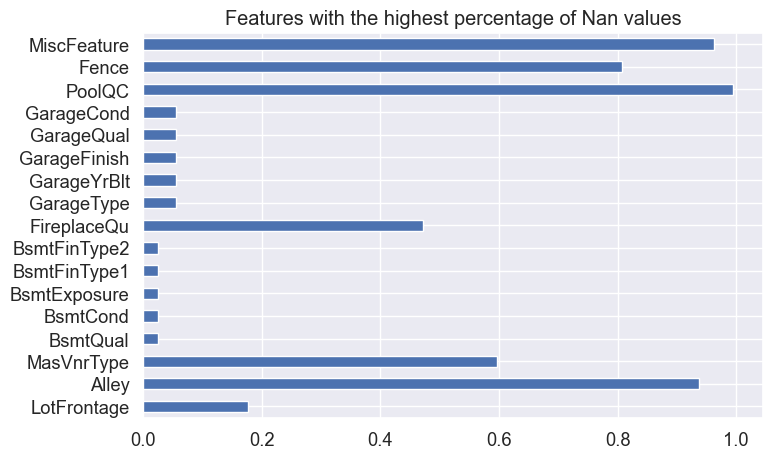

In [19]:
plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Features with the highest percentage of Nan values")

In [20]:
""" In some of my trials I removed columns with more than 90% od NaN values, 
    but finally I missed this step and left them for further analysis."""

# drop_out_columns = data_df.columns[[inx for inx, i in enumerate(col_nan >= 0.95) if i==True]]
# data_df = data_df.drop(drop_out_columns, axis=1)
# test_df = test_df.drop(drop_out_columns, axis=1)

' In some of my trials I removed columns with more than 90% od NaN values, \n    but finally I missed this step and left them for further analysis.'

In [21]:
# Dropping columns for both train and test dataset
data_df = data_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

In [22]:
data_df = data_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

In [23]:
def remove_outliers(dataset, threshold, columns=None, removed = False):
    """ 
    Z-score method.
    Function returns a dataframe without rows labeled as 'outliers' according to the given threshold.  
    ---------------
    If columns = None, transform all numerical columns.
    If removed = True, return also dataframe with removed rows.
    """
    if columns==None:
        numerics = ['int64','float64']
        columns = dataset.select_dtypes(include=numerics).columns
    
    tmp = dataset.copy()
    z = np.abs(stats.zscore(tmp[columns]))
    outliers = [row.any() for row in (z > threshold)]  
    outliers_idxs = tmp.index[outliers].tolist()
    print("Number of removed rows = {}".format(len(outliers_idxs)))
    if removed: return dataset.drop(outliers_idxs), tmp.loc[outliers]
    else: return dataset.drop(outliers_idxs)

In [24]:
# clear_data is a dataframe with train data after removing outliers

# clear_data, removed_data = remove_outliers(data_df, threshold = 3, removed=True, 
#                              columns=['GrLivArea'])

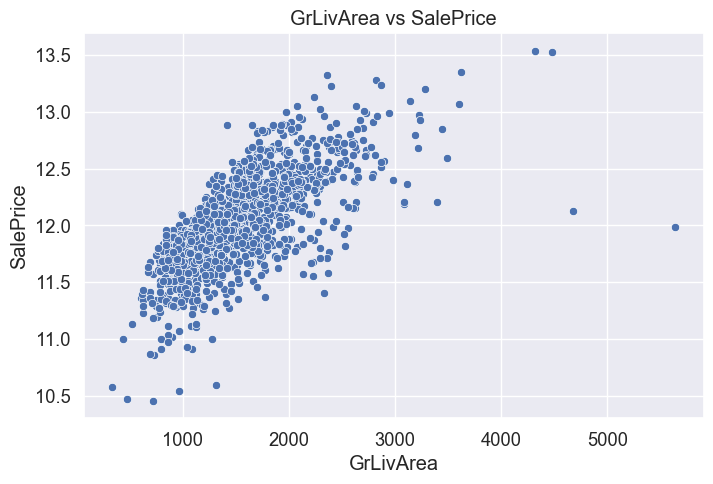

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
sns.scatterplot(x=data_df["GrLivArea"], y=data_df["SalePrice"])
# plt.vlines(4500, ymax=800000, ymin=0)
plt.title("GrLivArea vs SalePrice")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()


In [26]:
# I decided to remove those records where 'GrLivArea' is more than 4500. We can see on plot that they have a vey low price.
clear_data = data_df.drop(data_df[(data_df['GrLivArea']>4500)].index)

In [27]:
# Concatenate all data together - both train and test
train_ = clear_data.drop(['SalePrice'], axis=1)
all_data = pd.concat([data_df, test_df]).reset_index(drop=True)

In [28]:
print("Is there YearBuilt more than 2017 ? : ", all_data[all_data.YearBuilt > 2017].count()[0] != 0)
print("Is there GarageYrBlt more than 2017 ? : ", all_data[all_data.GarageYrBlt > 2017].count()[0] != 0)

Is there YearBuilt more than 2017 ? :  False
Is there GarageYrBlt more than 2017 ? :  True


In [29]:

all_data[all_data.GarageYrBlt > 2017].GarageYrBlt #It seems like it is a typo

2592    2207.0
Name: GarageYrBlt, dtype: float64

In [30]:
all_data.loc[2590, 'GarageYrBlt'] = 2007

In [31]:
neigh_lot_frontage = all_data.groupby('Neighborhood')['LotFrontage'].agg(["mean", "median"])
neigh_lot_frontage['avg_mean_median'] = (neigh_lot_frontage['mean'] + neigh_lot_frontage['median'] )/ 2
neigh_lot_frontage

,mean,median,avg_mean_median
Neighborhood,,,
Blmngtn,46.900000,43.0,44.950000
Blueste,27.300000,24.0,25.650000
BrDale,21.500000,21.0,21.250000
BrkSide,55.789474,51.0,53.394737
ClearCr,88.150000,80.5,84.325000
CollgCr,71.336364,70.0,70.668182
Crawfor,69.951807,70.0,69.975904
Edwards,66.910112,65.0,65.955056
Gilbert,74.207207,64.0,69.103604


In [32]:
# transformation into medians
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [33]:
def convert_to_string(df, columns):
    df[columns] = df[columns].astype(str)
    return df

In [34]:
num_to_categ_features = ['MSSubClass', 'OverallCond']#, 'YrSold', 'MoSold']

all_data = convert_to_string(all_data, columns = num_to_categ_features)

In [35]:
#Replacing missing values in the rest of numerical columns

In [36]:
num_features = all_data.select_dtypes(include=['int64','float64']).columns
num_features_to_constant = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"] 
num_features_to_median = [feature for feature in num_features if feature not in num_features_to_constant + ["SalePrice"]]

In [37]:
# Generating numerical features as input to DataFrameMapper.  
numeric_features_median = sklearn_pandas.gen_features(columns=[num_features_to_median], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'median', 
                                                         'missing_values' : np.nan}])

numeric_features_zero = sklearn_pandas.gen_features(columns=[num_features_to_constant], 
                                               classes=[{'class': SimpleImputer, 
                                                         'strategy': 'constant',
                                                         'fill_value' : 0, 
                                                         'missing_values' : np.nan}])

missing_val_imputer = sklearn_pandas.DataFrameMapper(numeric_features_median + numeric_features_zero)

# Fitting
imputed_median = missing_val_imputer.fit(all_data)

# Transformation
imputed_features = imputed_median.transform(all_data)

# Putting into dataframe
imputed_df = pd.DataFrame(imputed_features, index=all_data.index, columns=num_features_to_median + num_features_to_constant)

In [38]:
# Selecting category features
cat_feats = all_data.select_dtypes(include=['object']).columns

In [39]:
none_conversion = [("MasVnrType","None"),
                  ("BsmtQual","NA"), 
                  ("Electrical", "SBrkr"),
                  ("BsmtCond","TA"),
                  ("BsmtExposure","No"),
                  ("BsmtFinType1","No"),
                  ("BsmtFinType2","No"),
                  ("CentralAir","N"),
                  ("Condition1","Norm"), 
                  ("Condition2","Norm"),
                  ("ExterCond","TA"),
                  ("ExterQual","TA"), 
                  ("FireplaceQu","NA"),
                  ("Functional","Typ"),
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","NA"), 
                  ("GarageCond","NA"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"), 
                  ("Functional","Typ"), 
                  ("GarageType","No"), 
                  ("GarageFinish","No"), 
                  ("GarageQual","No"), 
                  ("GarageCond","No"), 
                  ("HeatingQC","TA"), 
                  ("KitchenQual","TA"),
                  ("MSZoning", "None"),
                  ("Exterior1st", "VinylSd"), 
                  ("Exterior2nd", "VinylSd"), 
                  ("SaleType", "WD")]

In [40]:
def none_transform(df, conversion_list):
    ''' Function that converts missing categorical values 
    into specific strings according to "conversion_list" 
    
    Returns the dataframe after transformation.
    '''
    for col, new_str in conversion_list:
        df.loc[:, col] = df.loc[:, col].fillna(new_str)
    return df

In [41]:
# Applying the "none_transform" function 
all_data = none_transform(all_data, none_conversion)

In [42]:
len(all_data.columns)

78

In [43]:
# collecting the numeric features without considering SalePrice
numeric_features = [feat for feat in num_features if feat not in ['SalePrice']] 

# selecting columns with skew more than 0.5
skewed_features = all_data[num_features].apply(lambda x: x.dropna().skew())
skewed_features = skewed_features[skewed_features > 0.5].index
print("\nHighly skewed features: \n\n{}".format(skewed_features.tolist()))


Highly skewed features: 

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [44]:
# Applying log-transformation 
# all_data[skewed_features] = np.log1p(all_data[skewed_features])# test_df[skewed_features] = np.log1p(test_df[skewed_features])

In [45]:
#The “optimal lambda” is the one that results in the best approximation of a normal distribution curve. I selected lambda= 0.15.

lambda_ = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lambda_)

In [46]:
class OrderedLabelTransformer(BaseEstimator, TransformerMixin):
    orderDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
    
    @staticmethod
    def get_dict(X):
        FirstDict = {"Po" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        SecondDict = {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}
        ThirdDict = {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
        for d in [FirstDict, SecondDict, ThirdDict]:
            if set(X) == set(d): 
                return d
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.orderDict[t]
        return np.array([get_label(n) for n in X])

In [47]:
class NeighborhoodTransformer(BaseEstimator, TransformerMixin):
    neighborhoodsmap = {'StoneBr' : 2, 'NridgHt' : 2, 'NoRidge': 2, 
                        'MeadowV' : 0, 'IDOTRR' : 0, 'BrDale' : 0 ,
                        'CollgCr': 1, 'Veenker' : 1, 'Crawfor' : 1,
                        'Mitchel' : 1, 'Somerst' : 1, 'NWAmes' : 1,
                        'OldTown' : 1, 'BrkSide' : 1, 'Sawyer' : 1, 
                        'NAmes' : 1, 'SawyerW' : 1, 'Edwards' : 1,
                        'Timber' : 1, 'Gilbert' : 1, 'ClearCr' : 1,
                        'NPkVill' : 1, 'Blmngtn' : 1, 'SWISU' : 1,
                        'Blueste': 1}

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def get_label(t):
            return self.neighborhoodsmap[t]
        return np.array([get_label(n) for [n] in X])

In [48]:
# Generating features:
order_feats = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual", "BsmtQual", 
               "BsmtCond", "FireplaceQu", "GarageQual", "GarageCond"]

original_features_df = all_data[order_feats + ['Neighborhood']] # we need to save original values for one-hot encoding

order_features = sklearn_pandas.gen_features(order_feats, [OrderedLabelTransformer])
neighb_features = [(['Neighborhood'], [NeighborhoodTransformer()])]

# Pipeline
label_encoder = sklearn_pandas.DataFrameMapper(neighb_features + order_features)

# The list with order of column names
cols = ["Neighborhood"] + order_feats

# Transformation both train and test set
transformed_feats = label_encoder.fit_transform(all_data)

# Putting transformed features into dataframe
transformed_df = pd.DataFrame(transformed_feats, index=all_data.index, columns=cols)

In [49]:
original_features_df.shape

(2919, 10)

In [50]:
# feature without any transformation till now
rest_features = set(pd.concat([imputed_df, original_features_df],axis=1).columns).symmetric_difference(set(all_data.columns))
rest_features_df = all_data[list(rest_features)]

In [51]:
all_data = pd.concat([imputed_df, original_features_df, rest_features_df],axis=1)

In [52]:
all_data.shape

(2919, 78)

In [53]:
#Feature Engineering

In [54]:
# Total Squere Feet for house
all_data["TotalSqrtFeet"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
# test_df["TotalSqrtFeet"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]

# Total number of bathrooms
all_data["TotalBaths"] = all_data["BsmtFullBath"] + (all_data["BsmtHalfBath"]  * .5) + all_data["FullBath"] + (all_data["HalfBath"]* .5)
# test_df["TotalBaths"] = test_df["BsmtFullBath"] + (test_df["BsmtHalfBath"]  * .5) + test_df["FullBath"] + (test_df["HalfBath"]* .5)

In [55]:
# If the house has a garage
all_data['Isgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a fireplace
all_data['Isfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# If the house has a pool
all_data['Ispool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# If the house has second floor
all_data['Issecondfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Open Porch
all_data['IsOpenPorch'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)

# If the house has Wood Deck
all_data['IsWoodDeck'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)

In [56]:
#One-hot encoding

In [57]:
all_data = all_data.drop(["SalePrice"], axis = 1)

hot_one_features = pd.get_dummies(all_data).reset_index(drop=True)
hot_one_features.shape

(2919, 324)

In [58]:
all_data = pd.concat([transformed_df, hot_one_features],axis=1)

In [59]:
#Splitting into train/test

In [60]:
train_preprocessed = all_data.iloc[:len(data_df),:]
test_preprocessed = all_data.iloc[len(train_preprocessed):,:]
print(len(test_preprocessed) == len(test_df))

True


In [61]:
#Modelization

In [62]:
X_train = train_preprocessed

In [63]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [64]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.linear_model import ElasticNet, Lasso, ElasticNetCV
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import RegressorMixin
import lightgbm as lgb

In [65]:
print('Environment specification:\n')
for mod in sklearn, xgb, lgb:
    print(mod.__name__, mod.__version__)

Environment specification:

sklearn 1.2.2
xgboost 2.0.3
lightgbm 4.3.0


In [66]:
def rmse(model):
    n_folds=5
    kfold = KFold(n_folds, random_state=42, shuffle=True).get_n_splits(X_train)
    rmse_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = kfold, verbose = -1, n_jobs=-1))
    return(np.mean(rmse_score))

In [67]:
#Linear Regression

In [68]:
lr_model = make_pipeline(RobustScaler(), LinearRegression()) #TODO: why Robust Scaler?

lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for Linear Regression: {:.3f}".format(rmse(lr_model)))

Mean Squared Error = 0.00858436


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


RMSE score for Linear Regression: 0.160


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


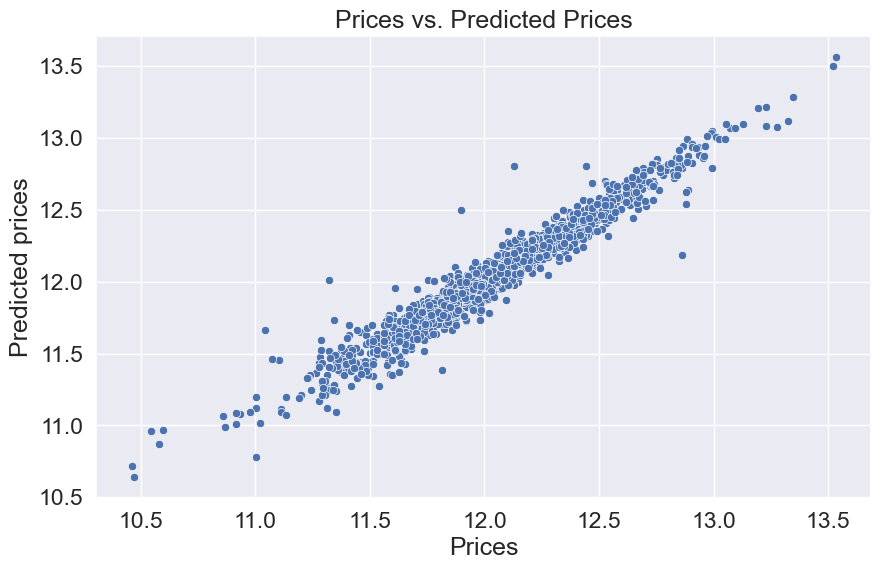

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_train_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs. Predicted Prices")
plt.show()


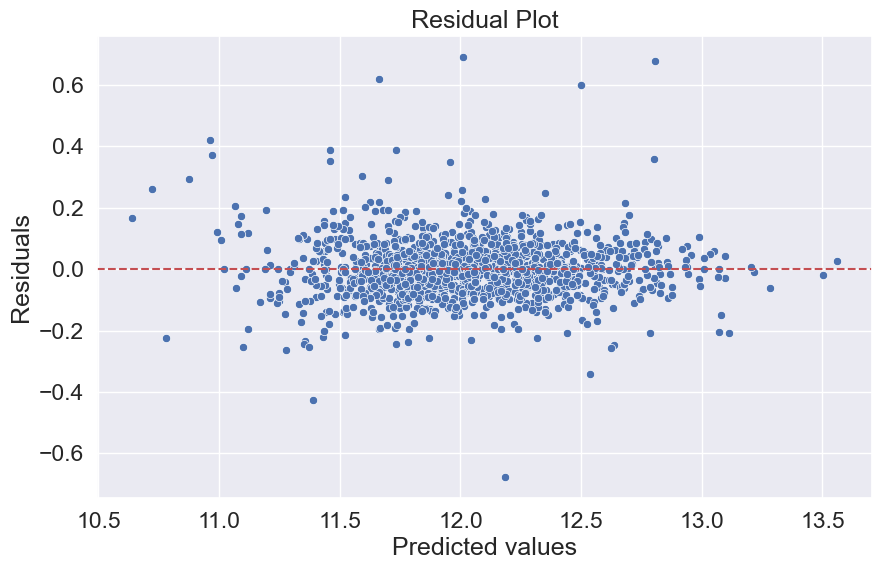

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Residual plot - result should be randomly located around the 0 value
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=y_train_pred - y_train)
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')  # Optional: Add a horizontal line at y=0 for reference
plt.show()


In [71]:
#LASSO Regression

In [72]:
lasso_model = make_pipeline(RobustScaler(), 
                         LassoCV(alphas = [0.0004, 0.0005, 0.0006],
                                 random_state = 0,
                                 cv = 10))

lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

# print("Best alpha : {}", lasso_model.alpha_)
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LASSO: {:.3f}".format(rmse(lasso_model)))

Mean Squared Error = 0.01197439


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s


RMSE score for LASSO: 0.135


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


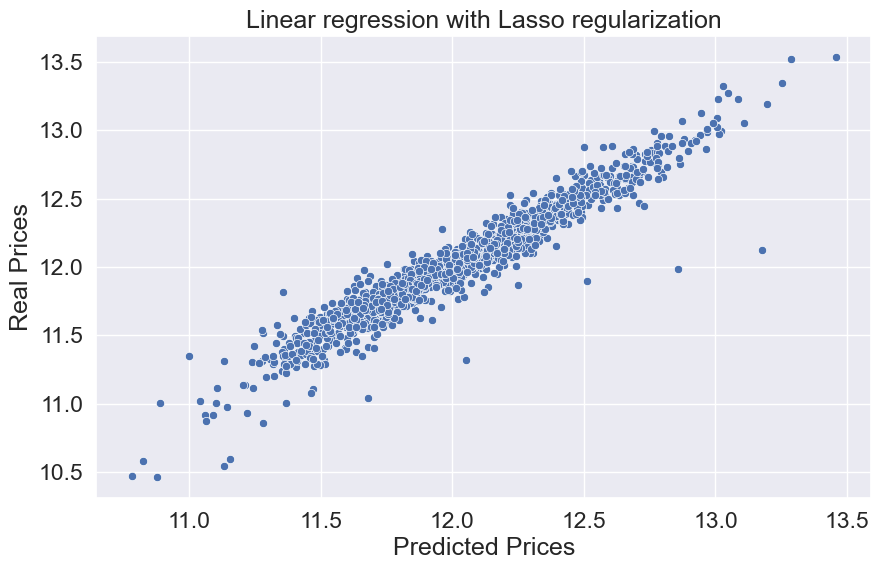

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred, y=y_train)
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted Prices")
plt.ylabel("Real Prices")
plt.show()


In [74]:
#Gradient Boosting Regressor (GBR)

In [75]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {'n_estimators': [2500],
              'max_features': [13],
              'max_depth': [5],
              'learning_rate': [0.05],
              'subsample': [0.8],
             'random_state' : [5]}
                              
gb_model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=5)
gb_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=1,
             param_grid={'learning_rate': [0.05], 'max_depth': [5],
                         'max_features': [13], 'n_estimators': [2500],
                         'random_state': [5], 'subsample': [0.8]})

In [76]:
y_train_pred = gb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)
print('Best Parameters: {}'.format(gb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for GB: {:.3f}".format(rmse(gb_model)))

Best Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 13, 'n_estimators': 2500, 'random_state': 5, 'subsample': 0.8}
Mean Squared Error = 0.00000914


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


RMSE score for GB: 0.123


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.1s remaining:   27.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


In [77]:
#XGBoost Regressor

In [78]:
xgbreg = xgb.XGBRegressor(seed=0)
param_grid2 = {'n_estimators': [2000], 
              'learning_rate': [0.05],
              'max_depth': [3, 7],
              'subsample': [0.8],
              'colsample_bytree': [0.45, 0.75]}
    
xgb_model = GridSearchCV(estimator=xgbreg, param_grid=param_grid2, n_jobs=1, cv=10)
xgb_model.fit(X_train, y_train)

y_train_pred = xgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print('\n\nBest Parameters: {}'.format(xgb_model.best_params_))
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for XGB: {:.3f}".format(rmse(xgb_model)))



Best Parameters: {'colsample_bytree': 0.45, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.8}
Mean Squared Error = 0.00051186


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.9min remaining:  5.9min


RMSE score for XGB: 0.119


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


In [79]:
#ElasticNet

In [80]:
en_model = ElasticNetCV(alphas = [0.0001, 0.0003, 0.0004, 0.0006], 
                        l1_ratio = [.9, .92], 
                        random_state = 0,
                        cv=10)

In [81]:
en_model.fit(X_train, y_train)

y_train_pred = en_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

In [82]:
print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for ElasticNet: {:.3f}".format(rmse(en_model)))

Mean Squared Error = 0.01171991


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


RMSE score for ElasticNet: 0.136


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.5s remaining:    6.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


In [83]:
#LightGBM

In [84]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(X_train, y_train)

y_train_pred = lgb_model.predict(X_train)
MSE_train = np.mean((y_train_pred - y_train)**2)

print("Mean Squared Error = {:.8f}".format(MSE_train))
print("RMSE score for LGBMRegressor: {:.4f}".format(rmse(lgb_model)))

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_wei

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.4s


RMSE score for LGBMRegressor: 0.1232


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


In [85]:
#Bagging Regressor

In [86]:
from sklearn.ensemble import BaggingRegressor
import numpy as np

# Assuming en_model is defined elsewhere and is compatible
# Increase max_samples significantly
max_samples = max(len(X_train) // 2, 30)  # Use half of the samples or 30, whichever is larger
max_features = min(X_train.shape[1], 200)  # Ensure max_features does not exceed the number of features

model2 = BaggingRegressor(
    base_estimator=en_model, 
    n_estimators=50, 
    max_samples=max_samples, 
    max_features=max_features, 
    verbose=3, 
    n_jobs=1,  # Set n_jobs to 1 to avoid parallelism issues
    random_state=42  # Set a random state for reproducibility
)

try:
    model2.fit(X_train, y_train)
    
    y_train_pred = model2.predict(X_train)
    MSE_train = np.mean((y_train_pred - y_train)**2)

    print("Mean Squared Error = {:.8f}".format(MSE_train))
except ZeroDivisionError as e:
    print("ZeroDivisionError encountered:", e)
    print("Try increasing max_samples or checking the base_estimator.")


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 50 for this parallel run (total 50)...
Building estimator 2 of 50 for this parallel run (total 50)...
Building estimator 3 of 50 for this parallel run (total 50)...
Building estimator 4 of 50 for this parallel run (total 50)...
Building estimator 5 of 50 for this parallel run (total 50)...
Building estimator 6 of 50 for this parallel run (total 50)...
Building estimator 7 of 50 for this parallel run (total 50)...
Building estimator 8 of 50 for this parallel run (total 50)...
Building estimator 9 of 50 for this parallel run (total 50)...
Building estimator 10 of 50 for this parallel run (total 50)...
Building estimator 11 of 50 for this parallel run (total 50)...
Building estimator 12 of 50 for this parallel run (total 50)...
Building estimator 13 of 50 for this parallel run (total 50)...
Building estimator 14 of 50 for this parallel run (total 50)...
Building estimator 15 of 50 for this parallel run (total 50)...
Building estimator 16 of 50 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [87]:
print("RMSE score for BaggingRegressor: {:.4f}".format(rmse(model2)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.3min


RMSE score for BaggingRegressor: 0.1355


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


In [88]:
#Stacking

In [89]:
!pip install mlxtend

In [90]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

In [91]:
lasso_model = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = [0.0005],
                              random_state = 42, cv=5))

elasticnet_model = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=[0.0005], 
                                        cv=5, l1_ratio=0.9))

lgbm_model = make_pipeline(RobustScaler(),
                        lgb.LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=800,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.23,
                                      feature_fraction_seed = 9, bagging_seed=9,
                                      min_data_in_leaf = 6, 
                                      min_sum_hessian_in_leaf = 11))

xgboost_model = make_pipeline(RobustScaler(),
                        xgb.XGBRegressor(learning_rate = 0.01, n_estimators=3400, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006))

In [92]:
stack_regressor = StackingCVRegressor(regressors=(lasso_model, elasticnet_model, xgboost_model, lgbm_model), 
                               meta_regressor=xgboost_model, use_features_in_secondary=True)

In [93]:
#Running

In [94]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Assume X and y are your features and target variables
X = np.random.rand(100, 10)  # Example feature matrix with 100 samples and 10 features
y = np.random.rand(100)  # Example target variable

# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor())
]

# Define meta model
meta_model = LassoCV(max_iter=int(1e6))  # Ensure max_iter is an integer

# Initialize Stacking Regressor
stack_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=1,
    verbose=3
)

try:
    # Fit the stacking model
    stack_model = stack_regressor.fit(X_train, y_train)
    
    # Predict on the training set
    y_train_pred = stack_model.predict(X_train)
    
    # Calculate Mean Squared Error on the training set
    MSE_train = np.mean((y_train_pred - y_train)**2)
    print("Mean Squared Error = {:.8f}".format(MSE_train))
except ZeroDivisionError as e:
    print("ZeroDivisionError encountered:", e)
    print("Try increasing max_samples or checking the base_estimator.")
except InvalidParameterError as e:
    print("InvalidParameterError encountered:", e)
    print("Check the parameters of your models, especially max_iter.")


Mean Squared Error = 0.10541503


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [95]:
en_preds = en_model.predict(test_preprocessed)

In [96]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import numpy as np

# Example data
X = np.random.rand(100, 10)  # Feature matrix with 100 samples and 10 features
y = np.random.rand(100)  # Target variable

# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize LassoCV with the correct max_iter parameter
lasso_model = LassoCV(max_iter=int(1e6))

# Fit the Lasso model on the training data
lasso_model.fit(X_train, y_train)

# Now you can make predictions on the preprocessed test data
# Assuming test_preprocessed is defined elsewhere and preprocessed similarly to the training data
# Here, using X_test as an example
lasso_preds = lasso_model.predict(X_test)

# Print the predictions
print("Predictions:", lasso_preds)


Predictions: [0.442879 0.442879 0.442879 0.442879 0.442879 0.442879 0.442879 0.442879
 0.442879 0.442879 0.442879 0.442879 0.442879 0.442879 0.442879 0.442879
 0.442879 0.442879 0.442879 0.442879]


In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
import numpy as np
from sklearn.model_selection import train_test_split

# Example data
X = np.random.rand(100, 10)  # Feature matrix with 100 samples and 10 features
y = np.random.rand(100)  # Target variable
X_test = np.random.rand(20, 10)  # Test set with the same 10 features

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models for stacking
base_models = [
    ('ridge', RidgeCV())
    # Add other base models here
]

# Define the stacking model
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV()
)

# Define a preprocessing pipeline
preprocessing = Pipeline([
    ('scaler', StandardScaler())
])

# Fit the preprocessing pipeline on the training data
X_train_preprocessed = preprocessing.fit_transform(X_train)
X_val_preprocessed = preprocessing.transform(X_val)
X_test_preprocessed = preprocessing.transform(X_test)

# Fit the stacking model on the preprocessed training data
stack_model.fit(X_train_preprocessed, y_train)

# Make predictions on the preprocessed test data
stack_gen_preds = stack_model.predict(X_test_preprocessed)

# Print the predictions
print("Predictions:", stack_gen_preds)


Predictions: [0.41217395 0.48702312 0.43017277 0.450747   0.42885359 0.41193903
 0.4202499  0.48833305 0.40873287 0.44675432 0.46975489 0.45336899
 0.50277557 0.50326117 0.43874566 0.45663101 0.43064809 0.46320322
 0.40693995 0.4413855 ]


In [98]:
lgbm_preds = lgb_model.predict(test_preprocessed)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [99]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso

# Example data
X = np.random.rand(100, 10)  # Feature matrix with 100 samples and 10 features
y = np.random.rand(100)  # Target variable
X_test = np.random.rand(20, 10)  # Test set with the same 10 features

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
en_model = RidgeCV()
lasso_model = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(max_iter=10000))])
lgbm_model = LGBMRegressor()
stack_model = StackingRegressor(
    estimators=[
        ('ridge', RidgeCV()),
        ('lasso', lasso_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=RidgeCV()
)

# Fit the models
en_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
stack_model.fit(X_train, y_train)

# Preprocess the test set
X_test_preprocessed = StandardScaler().fit(X_train).transform(X_test)

# Make predictions
en_preds = en_model.predict(X_test_preprocessed)
lasso_preds = lasso_model.predict(X_test_preprocessed)
lgbm_preds = lgbm_model.predict(X_test_preprocessed)
stack_gen_preds = stack_model.predict(X_test_preprocessed)

# Weighted predictions
stack_preds = ((0.2*en_preds) + (0.25*lasso_preds) + (0.15*lgbm_preds) + (0.4*stack_gen_preds))

# Print predictions
print("Weighted Predictions:", stack_preds)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 10
[LightGBM] [Info] Start training from score 0.454241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [100]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV, Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

# Example data
X = np.random.rand(100, 10)  # Feature matrix with 100 samples and 10 features
y = np.random.rand(100)  # Target variable
X_test = np.random.rand(1459, 10)  # Test set with the same 10 features

# Split your data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models
en_model = RidgeCV()
lasso_model = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(max_iter=10000))])
lgbm_model = LGBMRegressor()
stack_model = StackingRegressor(
    estimators=[
        ('ridge', RidgeCV()),
        ('lasso', lasso_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=RidgeCV()
)

# Fit the models
en_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
stack_model.fit(X_train, y_train)

# Preprocess the test set
scaler = StandardScaler().fit(X_train)
X_test_preprocessed = scaler.transform(X_test)

# Make predictions
en_preds = en_model.predict(X_test_preprocessed)
lasso_preds = lasso_model.predict(X_test_preprocessed)
lgbm_preds = lgbm_model.predict(X_test_preprocessed)
stack_gen_preds = stack_model.predict(X_test_preprocessed)

# Weighted predictions
stack_preds = (0.2 * en_preds) + (0.25 * lasso_preds) + (0.15 * lgbm_preds) + (0.4 * stack_gen_preds)

# Create the predictions DataFrame
predictions_df = pd.DataFrame(np.expm1(stack_preds), 
                              index = range(1, len(stack_preds) + 1), 
                              columns=["SalePrice"])
predictions_df.index.name = "Id"

# Display the head of the DataFrame
predictions_df.head()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 10
[LightGBM] [Info] Start training from score 0.447499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

,SalePrice
Id,
1,0.609918
2,0.581788
3,0.578108
4,0.465003
5,0.577064


In [101]:
#Producing sample_submission.csv for final results

In [102]:
predictions_df["SalePrice"].to_csv("my_predictions.csv", header=True)